# Classifier

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
from torch.utils.data import random_split, ConcatDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import time
import os
import argparse
from sklearn.metrics import confusion_matrix
from google.colab import drive
import matplotlib.pyplot as plt
import pickle

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# 0.Setting

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
parser = argparse.ArgumentParser()
parser.add_argument('--workers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--epoch', type=int, default=30)
parser.add_argument('--lr', type=float, default=0.002)
parser.add_argument('--seed', type=int, default=1000)
parser.add_argument('--nc', type=int, default=5) # number of class

args = parser.parse_args("") # 本地去掉""， colab加上"" ！！！！！！


all_defaults = {}
for key in vars(args):
  all_defaults[key] = parser.get_default(key)
all_defaults


{'batch_size': 64,
 'epoch': 30,
 'lr': 0.002,
 'nc': 5,
 'seed': 1000,
 'workers': 4}

# 1. Load Dataset

In [ ]:
transformEdge=transforms.Compose([transforms.Resize((96,96)),transforms.ToTensor(),transforms.Normalize((0.9474, 0.9474, 0.9474), (0.2038, 0.2038, 0.2038))])
transformSketch=transforms.Compose([transforms.Resize((96,96)),transforms.ToTensor(),transforms.Normalize((0.9474, 0.9474, 0.9474), (0.2038, 0.2038, 0.2038))])

# location on Google Drive
sketch_data_path = "/content/drive/My Drive/Data/sketchy-database/Final Edgemaps"
edge_data_path = "/content/drive/My Drive/Data/STL-10/STL edge maps"
# load  data file from Google Drive
sketch_dataset = torchvision.datasets.ImageFolder(root=sketch_data_path,transform=transformEdge)
print(len(sketch_dataset))
edge_dataset = torchvision.datasets.ImageFolder(root=edge_data_path,transform=transformSketch)
print(len(edge_dataset))

data = ConcatDataset([sketch_dataset, edge_dataset])

# Calculate split lengths
total_size = len(data)
#print(sketch_dataset.size())
train_size = round(0.9*total_size)
valid_size = round(0.05*total_size)
test_size = round(0.05*total_size)-1
print(train_size,valid_size,test_size)

# Seperate into Train, Val and Test sets
seed = 0
train_set, valid_set, test_set = random_split(data, [train_size,valid_size,test_size], generator=torch.Generator().manual_seed(seed))
# show the size of each dataset
print("# Train Set: " + str(len(train_set)))
print("# Test Set: " + str(len(valid_set)))
print("# Val Set: " + str(len(test_set)))

# Load raw data (not normalized)
#raw_data_loader = DataLoader(dataset=raw_dataset,batch_size=256,num_workers=2)
# Compute image dataset channel wise the mean and standard deviation 
#mean=0.0
#std=0.0
#cnt = 0
#pr = 0
#print(pr)
#for batch, _ in raw_data_loader:
 # print(pr)
  # Rearrange batch to be the shape of [B, C, W * H]
 # batch = batch.view(batch.size(0),batch.size(1), -1)
  # Update total number of images
 # cnt += batch.size(0)
  # Compute mean and std here
  #mean += batch.mean(2).sum(0) 
 # std += batch.std(2).sum(0)
 # pr += 1
# Final step
#mean /= cnt
#std /= cnt
#print(mean)
#print(std)
#print(cnt)

2500
2375
4388 244 243
# Train Set: 4388
# Test Set: 244
# Val Set: 243


In [ ]:
# Prepare Dataloader
train_data_loader = DataLoader(dataset=train_set,batch_size=args.batch_size, shuffle=True)
val_data_loader = DataLoader(dataset=valid_set,batch_size=args.batch_size, shuffle=True)
test_data_loader = DataLoader(dataset=test_set,batch_size=args.batch_size, shuffle=True)

In [ ]:
for batch_images, targets in train_data_loader:
    print(batch_images.shape)  

torch.Size([64, 3, 96, 96])
torch.Size([64, 3, 96, 96])
torch.Size([64, 3, 96, 96])
torch.Size([64, 3, 96, 96])


KeyboardInterrupt: ignored

In [ ]:
# Print Image Size: 3 * 256 * 256, batch size = 32, label: 0~4
for i,data in enumerate(val_data_loader):
    input,label = data # The label here is useless, they all have label == 1: real image
    print(input.size(),label)

KeyboardInterrupt: ignored

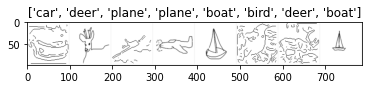

In [ ]:
# show some training images
class_names = ('plane','bird','car','boat','deer')
display_loader = DataLoader(dataset=train_set,batch_size=8, shuffle=True) 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.9619, 0.9619, 0.9619])
    std = np.array([0.1867, 0.1867, 0.1867])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
inputs,classes = next(iter(display_loader))
imshow(torchvision.utils.make_grid(inputs), title=[class_names[i] for i in classes])

# 2. Model

In [ ]:
!nvidia-smi
# Classification Net
resnet50 = models.resnet50(pretrained=True).to(device)
# Turn on update all params
for param in resnet50.parameters():
  param.requires_grad = True

Mon Nov 30 23:36:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    33W /  70W |   1127MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.name = 'classifier'
        self.fc1 = nn.Linear(1000, 5000)
        self.fc2 = nn.Linear(5000, 320)
        self.fc3 = nn.Linear(320, 5)

    def forward(self, x):
        x = x.view(-1, 1000)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 3. Helper Functions

In [ ]:
## In search of elegance
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
########################### Training Result ####################################         
def evaluate(transfer,model, data_loader, criterion):
  total_val_loss = 0.0
  total_val_err = 0.0
  total_epoch = 0 
  for i, data in enumerate(data_loader, 0):
    # Get the inputs
    inputs, label = data
    inputs = inputs.to(device)
    # make changes to the label (one-hot encoding)
    labels = torch.zeros(len(label),args.nc).float()
    labels = labels.to(device)
    for j in range(len(label)):
      index = label[j].item()
      labels[j][index] = 1.0
    outputs = model(transfer(inputs))
    loss = criterion(outputs, labels.float())
    #select index with maximum prediction score
    pred = outputs.max(1, keepdim=True)[1]
    pred = pred.cpu()
    labels = labels.cpu()
    total_val_err += pred.eq(label.view_as(pred)).sum().item()
    total_val_loss += loss.item()
    total_epoch += len(label)
  val_err = float(total_val_err) / (total_epoch)
  val_loss = float(float(total_val_loss) / (i+1))
  return val_err,val_loss
############################ Training Curve ####################################
def plot_train_val_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# 4. Training

In [ ]:
def train(transfer,net,batch_size=10,learning_rate=0.01,num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # load model
    criterion = nn.BCEWithLogitsLoss()
    # set up optimizer, update weights for model and resnet18
    param = [] # put the weights in a list
    for i in transfer.parameters():
      param.append(i)
    for j in net.parameters():
      param.append(j) 
    optimizer = optim.Adam(param, lr=learning_rate)
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_data_loader, 0):
            # Get the inputs
            inputs, label = data
            inputs = inputs.to(device)
            # make changes to the label (one-hot encoding)
            labels = torch.zeros(len(label),args.nc).float()
            for j in range(len(label)):
              index = label[j].item()
              labels[j][index] = 1.0
            labels = labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(transfer(inputs))
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            #select index with maximum prediction score
            pred = outputs.max(1, keepdim=True)[1]
            pred = pred.cpu()
            labels = labels.cpu()
            total_train_err += pred.eq(label.view_as(pred)).sum().item()
            total_train_loss += loss.item()
            total_epoch += len(labels)
            if i%10 == 0:
              print(i)
        train_err[epoch] = float(total_train_err) / (total_epoch)
        train_loss[epoch] = float(float(total_train_loss) / (i+1))
        val_err[epoch],val_loss[epoch] = evaluate(transfer,net,val_data_loader, criterion)
        print(("Epoch {}: Train Accuracy: {:.3f}, Train loss: {:.3f}, \n  Validation Accuracy: {:.3f}, Validation loss: {:.3f}\n ").format(
                   epoch + 1,train_err[epoch],train_loss[epoch],val_err[epoch],val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch+1)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


    torch.save({'classifier': classifier.state_dict(),
                'optimizer': optimizer.state_dict()
                }, f"classifier.pth")
    return True

In [ ]:
classifier = Classifier().to(device)
train(resnet50, classifier,batch_size=args.batch_size,learning_rate=args.lr,num_epochs=args.epoch)

0
10
20
30
40
50
60
Epoch 1: Train Accuracy: 0.543, Train loss: 0.433, 
  Validation Accuracy: 0.803, Validation loss: 0.229
 
0
10
20
30
40
50
60
Epoch 2: Train Accuracy: 0.804, Train loss: 0.205, 
  Validation Accuracy: 0.799, Validation loss: 0.180
 
0
10
20
30
40
50
60
Epoch 3: Train Accuracy: 0.861, Train loss: 0.157, 
  Validation Accuracy: 0.803, Validation loss: 0.187
 
0
10
20
30
40
50
60
Epoch 4: Train Accuracy: 0.893, Train loss: 0.124, 
  Validation Accuracy: 0.828, Validation loss: 0.191
 
0
10
20
30
40
50
60
Epoch 5: Train Accuracy: 0.915, Train loss: 0.096, 
  Validation Accuracy: 0.865, Validation loss: 0.155
 
0
10
20
30
40
50
60
Epoch 6: Train Accuracy: 0.918, Train loss: 0.098, 
  Validation Accuracy: 0.869, Validation loss: 0.160
 
0
10
20
30
40
50
60
Epoch 7: Train Accuracy: 0.938, Train loss: 0.066, 
  Validation Accuracy: 0.898, Validation loss: 0.129
 
0
10
20
30
40
50
60
Epoch 8: Train Accuracy: 0.943, Train loss: 0.065, 
  Validation Accuracy: 0.893, Validatio

True

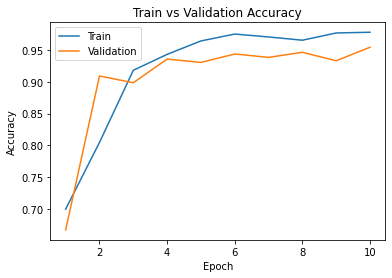

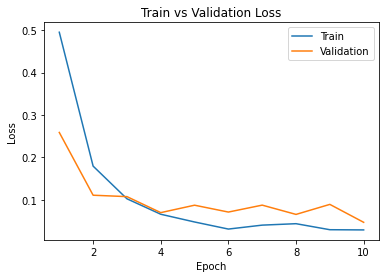

In [ ]:
path = get_model_name('classifier', batch_size=args.batch_size, learning_rate=args.lr, epoch=args.epoch)
plot_train_val_curve(path)

# 5. Test

In [ ]:
criterion = nn.BCEWithLogitsLoss()
transfer = resnet18
net = classifier
test_err,test_loss = evaluate(transfer,net,test_data_loader, criterion)
# Final Test Accuracy and loss 
print(test_err,test_loss)

0.9466666666666667 0.05832439692070087


# 6. Demo

In [ ]:
transformEdge=transforms.Compose([transforms.Resize((96,96)),transforms.ToTensor()])
transformSketch=transforms.Compose([transforms.Resize((96,96)),transforms.ToTensor()])
# location on Google Drive
sketch_data_path = "/content/drive/My Drive/Data/sketchy-database/Final Edgemaps"
edge_data_path = "/content/drive/My Drive/Data/STL-10/STL edge maps"
# load  data file from Google Drive
sketch_dataset = torchvision.datasets.ImageFolder(root=sketch_data_path,transform=transformEdge)
edge_dataset = torchvision.datasets.ImageFolder(root=edge_data_path,transform=transformSketch)
data = ConcatDataset([sketch_dataset, edge_dataset])
# Calculate split lengths
total_size = len(data)
#print(sketch_dataset.size())
train_size = round(0.9*total_size)
valid_size = round(0.05*total_size)
test_size = round(0.05*total_size)-1
# Seperate into Train, Val and Test sets
seed = 0
train_set, valid_set, test_set = random_split(data, [train_size,valid_size,test_size], generator=torch.Generator().manual_seed(seed))
test_data_loader = DataLoader(dataset=test_set,batch_size=20, shuffle=True)

torch.Size([20, 3, 96, 96])
(296, 786, 3)


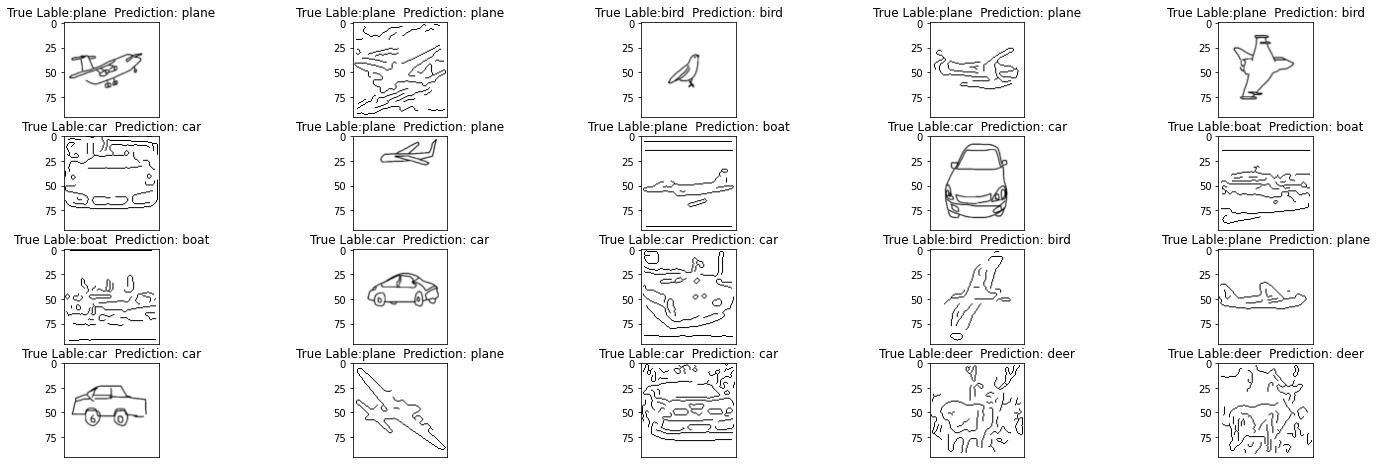

In [ ]:
test_data_loader = DataLoader(dataset=test_set,batch_size=20, shuffle=True)
dataiter = iter(test_data_loader)
inputs,label = dataiter.next()
inputs = inputs.to(device)
# make changes to the label (one-hot encoding)
labels = torch.zeros(len(label),args.nc).float()
for j in range(len(label)):
    index = label[j].item()
    labels[j][index] = 1.0
labels = labels.to(device)
outputs = classifier(resnet50(inputs))
#select index with maximum prediction score
pred = outputs.max(1, keepdim=True)[1]
pred = pred.cpu()
labels = labels.cpu()
inputs = inputs.cpu()
classes = ['plane','bird','car','boat','deer']
fig = plt.figure(figsize=(25,8))
print(inputs.size())
print(new_input.shape)
for idx in np.arange(20):
  ax = fig.add_subplot(4,5,idx+1,xticks=[])
  plt.imshow(np.transpose(inputs[idx],(1,2,0)))
  #plt.imshow(inputs)
  ax.set_title(("True Lable:{}  Prediction: {}").format(classes[label[idx]],classes[pred[idx]]))

In [ ]:
# plot confusion matrix 
from sklearn.metrics import confusion_matrix
test=DataLoader(dataset=test_set,batch_size=375, shuffle=True)
for i,data in enumerate(test):
  # Get the inputs
  inputs, label = data
  inputs = inputs.to(device)
  # make changes to the label (one-hot encoding)
  labels = torch.zeros(len(label),args.nc).float()
  for j in range(len(label)):
    index = label[j].item()
    labels[j][index] = 1.0
  labels = labels.to(device)
  outputs = classifier(resnet18(inputs))
  #select index with maximum prediction score
  pred = outputs.max(1, keepdim=True)[1]
  pred = pred.cpu()
  labels = labels.cpu()
  inputs = inputs.cpu()

In [ ]:
prediction = []
true = []
classes = ['plane','bird','car','boat','deer']
for j in range(375):
   temp = classes[pred[j]] 
   prediction.append(temp)
   tempp = classes[label[j]]
   true.append(tempp)
print(len(prediction))
print(len(true))

375
375


[[72  1  1  0  2]
 [ 2 57  0  0  0]
 [ 4  0 76  0  0]
 [ 0  0  0 78  1]
 [ 4  2  0  0 75]]


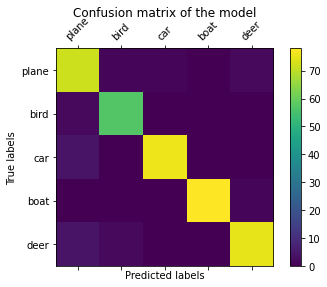

In [ ]:
cm = confusion_matrix(true, prediction, classes)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the model\n')
fig.colorbar(cax)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.show()